# Computer Vision project 3 - final report

Team members: Joanna Działo 148260, Wojciech Majewski 148253

Selected problem: Colourization -
We will attempt to accurately colour greyscale images using Neural Networks.

Dataset: https://paperswithcode.com/dataset/spair-71k

### Problem description:

The goal of this project is to accurately predict the original colors of a greyscale image. Our dataset contains colored images, from which we generate their greyscale counterparts. 

### Dataset

In [1]:
import cv2
import numpy as np
import os
from collections import deque
from google.colab.patches import cv2_imshow
import math
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Install the PyDrive wrapper & import libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1w7NEwuJV1kRYZsIR-_Qz9mlALpLX5CVe'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [3]:
!unzip JPEGImages.zip
!rm -rf JPEGImages.zip

Archive:  JPEGImages.zip
replace JPEGImages/aeroplane/2008_000585.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
def load_images(path, category, limit = None):
    category_path = os.path.join(path, category)
    images_paths = [os.path.join(category_path,img) for img in os.listdir(category_path)]
    images = [cv2.resize(cv2.imread(f, 1), (256, 256)) for f in images_paths]
    grey = [cv2.cvtColor(cv2.resize(cv2.imread(f, 1), (256, 256)), cv2.COLOR_BGR2GRAY) for f in images_paths]
    if limit == None:
        return images, grey
    else:
        limit_norm = min(limit, len(images))
        return images[:limit_norm], grey[:limit_norm]

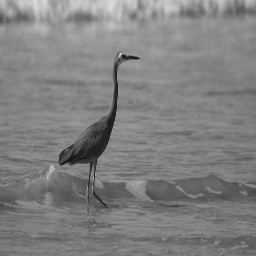

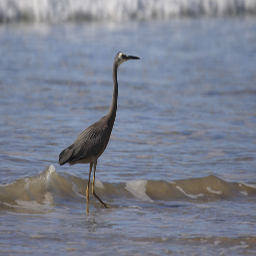

In [5]:
bird_images, bird_grey = load_images("/content/JPEGImages", "bird")
cv2_imshow(bird_grey[0])
cv2_imshow(bird_images[0])

In [6]:
bird_images[0].shape

(256, 256, 3)

In [7]:
def create_dataset(path, categories = None, limit = None):
    if categories == None:
        categories = os.listdir(path)
    X = []
    y = []
    for category in categories:
        if limit == None:
            images, greys = load_images(path, category)
        else:
            images, greys = load_images(path, category, limit)
        y.extend(images)
        X.extend(greys)
    return X, y

In [8]:
X_all, y_all = create_dataset("/content/JPEGImages")

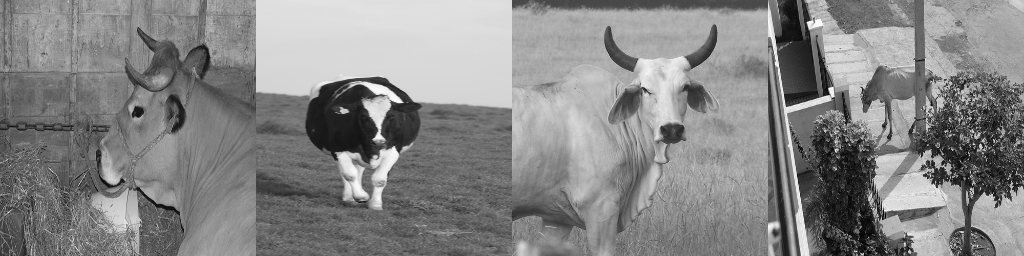

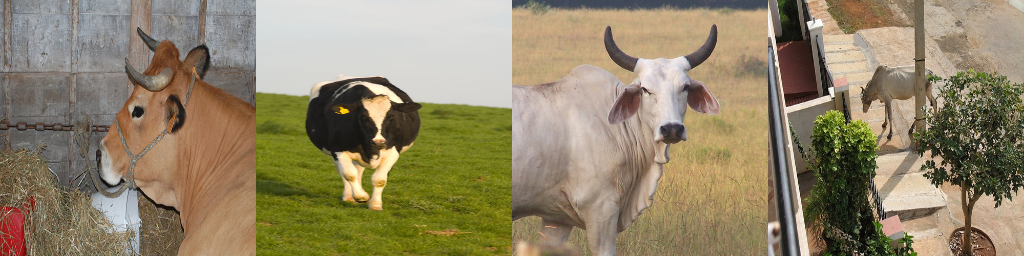

In [9]:
cv2_imshow(np.concatenate((X_all[0], X_all[1], X_all[2], X_all[3]), 1))
cv2_imshow(np.concatenate((y_all[0], y_all[1], y_all[2], y_all[3]), 1))

In [10]:
for image in X_all:
    if(image.shape[0] != 256 or image.shape[1] != 256):
        print('scream')

### Divide into Train and Test dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.7, random_state=148253)

In [12]:
len(X_train)

1260

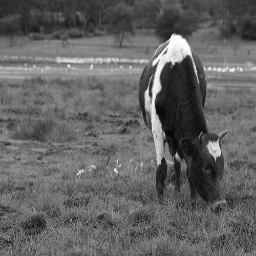

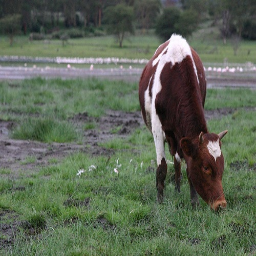

In [13]:
cv2_imshow(X_train[0])
cv2_imshow(y_train[0])

### Model (Work in progress for full scale model)

In [14]:
# WIP

### Training (Work in progress)

In [15]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Simplified problem, overfitting example

In [16]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave, imshow
import numpy as np
import os
import random
import tensorflow as tf

In [17]:
# Single image
image = img_to_array(load_img('JPEGImages/cat/2007_001825.jpg', target_size=(400, 400)))
image = np.array(image, dtype=float)

In [18]:
X = rgb2lab(1.0/255*image)[:,:,0] # Greyscale (L) channel of L*a*b
Y = rgb2lab(1.0/255*image)[:,:,1:] # a and b channels of L*a*b
Y /= 128 # values in lab are in range -128 to 128, and the neural network will return values in -1 to 1 range, so we standardize
X = X.reshape(1, 400, 400, 1)
Y = Y.reshape(1, 400, 400, 2)

Simple sequential convolutional neural network model

In [19]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 8)     80        
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 8)     584       
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    2320      
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 32)    4640      
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, None, None, 32)   0

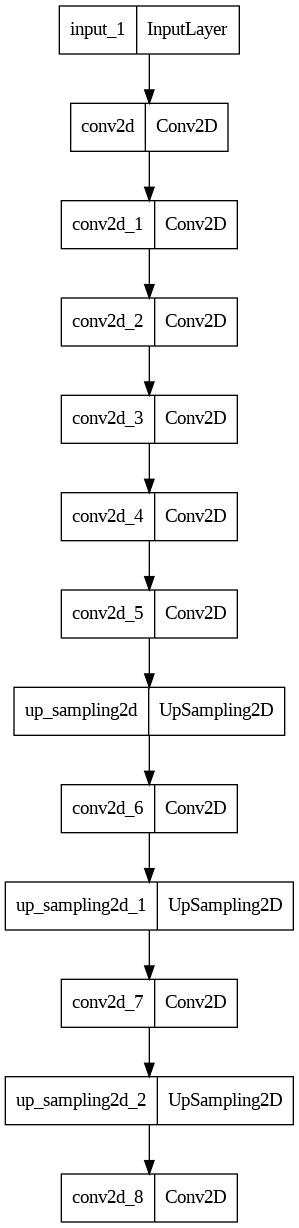

In [20]:
model.summary()
tf.keras.utils.plot_model(model)

In [21]:
model.compile(optimizer='rmsprop',loss='mse')

In [22]:
model.fit(x=X, 
    y=Y,
    batch_size=1,
    epochs=1000)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0437
Epoch 2/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.0328
Epoch 3/1000
1/1 [==============================] - 0s 321ms/step - loss: 0.0225
Epoch 4/1000
1/1 [==============================] - 0s 461ms/step - loss: 0.0223
Epoch 5/1000
1/1 [==============================] - 0s 331ms/step - loss: 0.0169
Epoch 6/1000
1/1 [==============================] - 0s 424ms/step - loss: 0.0153
Epoch 7/1000
1/1 [==============================] - 1s 569ms/step - loss: 0.0419
Epoch 8/1000
1/1 [==============================] - 1s 602ms/step - loss: 0.0240
Epoch 9/1000
1/1 [==============================] - 1s 541ms/step - loss: 0.0211
Epoch 10/1000
1/1 [==============================] - 1s 603ms/step - loss: 0.0181
Epoch 11/1000
1/1 [==============================] - 1s 543ms/step - loss: 0.0151
Epoch 12/1000
1/1 [==============================] - 0s 385ms/step - loss: 0.0127
Epoch 13/1000
1/1 [=========

In [23]:
print(model.evaluate(X, Y, batch_size=1))

1/1 [==============================] - 0s 247ms/step - loss: 8.9600e-04
0.000895995122846216


1/1 [==============================] - 0s 228ms/step


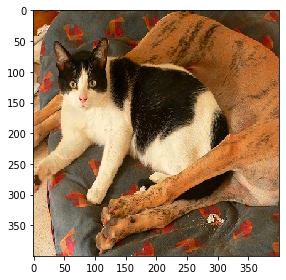

In [24]:
output = model.predict(X)
output *= 128

cur = np.zeros((400, 400, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]

imshow(lab2rgb(cur))

As we can see the model learned very well how to color this particular image

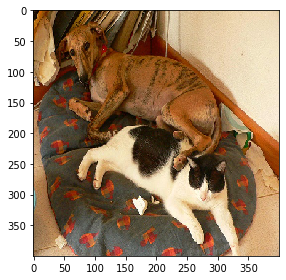

1/1 [==============================] - 0s 87ms/step


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 52 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


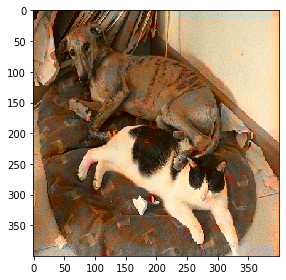

In [25]:
# Another image
image = img_to_array(load_img('JPEGImages/cat/2007_002597.jpg', target_size=(400, 400)))
image = np.array(image, dtype=float)
image = 1.0/255*image
imshow(image)
plt.show()

X = rgb2lab(image)[:,:,0]
X = X.reshape(1, 400, 400, 1)
output = model.predict(X)
output *= 128

cur = np.zeros((400, 400, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]

imshow(lab2rgb(cur))
plt.show()

As expected, the model trained on a train sample far too small, so any image given to it will be colored incorrectly

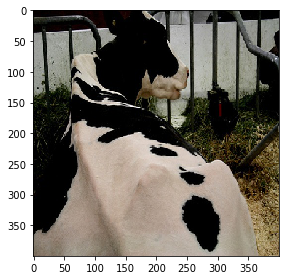

1/1 [==============================] - 0s 86ms/step


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2358 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


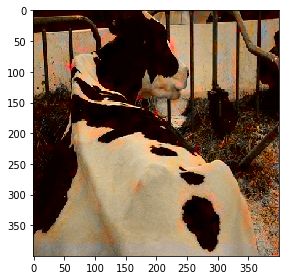

In [26]:
# Another image
image = img_to_array(load_img('JPEGImages/cow/2007_000491.jpg', target_size=(400, 400)))
image = np.array(image, dtype=float)
image = 1.0/255*image
imshow(image)
plt.show()

X = rgb2lab(image)[:,:,0]
X = X.reshape(1, 400, 400, 1)
output = model.predict(X)
output *= 128

cur = np.zeros((400, 400, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]

imshow(lab2rgb(cur))
plt.show()